In [1]:
import numpy as np
import sqlite3
import os

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers


In [38]:
IMAGE_SIZE = (400, 150, 3)
RESIZED_SIZE = (100, 50, 3)
RESIZED_SIZE_PIL = (RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2])
DATASET_PATH = "./data/"
DATASET_PATH = os.path.abspath(DATASET_PATH)
CLASSES = ["octane", "aftershock", "werewolf", "breakout"]

print(DATASET_PATH)

AUTOTUNE = tf.data.experimental.AUTOTUNE
VALIDATION_SPLIT = 0.15
BATCH_SIZE = 32
SHUFFLE_SIZE = 64
LIMIT = 1000
EPOCHS = 1


/tmp/deepl/data


In [52]:
def customGenerator():
    # get uuid and model list from sqlite db
    data = (
        sqlite3.connect(f"{DATASET_PATH}/index.db")
        .execute(f"SELECT uuid, model from data ORDER BY RANDOM() LIMIT {LIMIT}") # TODO: dataset may be unbalanced, fix
        .fetchall()
    )

    # load uuids to images and pre-process them
    for uuid, model in data:
        img = tf.io.read_file(f"{DATASET_PATH}/{uuid}.jpg")
        img = tf.image.decode_jpeg(img, channels=IMAGE_SIZE[2])
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, RESIZED_SIZE_PIL[:-1])

        label = tf.convert_to_tensor(model, dtype=tf.uint8)

        yield img, label


def set_shapes(image, label):
    image.set_shape(RESIZED_SIZE_PIL)
    label.set_shape([])
    return image, label


def cutout(image, label):
    img = tfa.image.random_cutout(image, (6, 6), constant_values=1)
    return (img, label)


def rotate(image, label):
    img = tfa.image.rotate(image, tf.constant(np.pi))
    return (img, label)


In [53]:
dataset = tf.data.Dataset.from_generator(generator=customGenerator, output_types=(tf.float32, tf.uint8))

# get dataset's length, using sqlite3 since the dataset built by tensorflow has an unknown cardinality
(dataset_length,) = sqlite3.connect(f"{DATASET_PATH}/index.db").execute("SELECT count(uuid) from data").fetchone()
dataset_length = min(dataset_length, LIMIT)

nb_batchs = dataset_length // BATCH_SIZE
train_size = int((1 - VALIDATION_SPLIT) * nb_batchs)

# print(f"""
#     dataset_length = {dataset_length}
#     batch size = {BATCH_SIZE}
#     number of batchs = {nb_batchs}

#     train_size = {train_size}
#     validation_size = {nb_batchs - train_size}
# """)

# pre-process a bit the dataset
dataset_batched = (
    dataset.shuffle(SHUFFLE_SIZE) # randomize the dataset
    .map(set_shapes) # fix bugged shapes
    .batch(BATCH_SIZE) # batch data
    # .map(cutout)
    .prefetch(AUTOTUNE) # use prefetch to enhance performances
)

# split the datasets
dataset_train = dataset_batched.take(train_size)
dataset_validate = dataset_batched.skip(train_size)


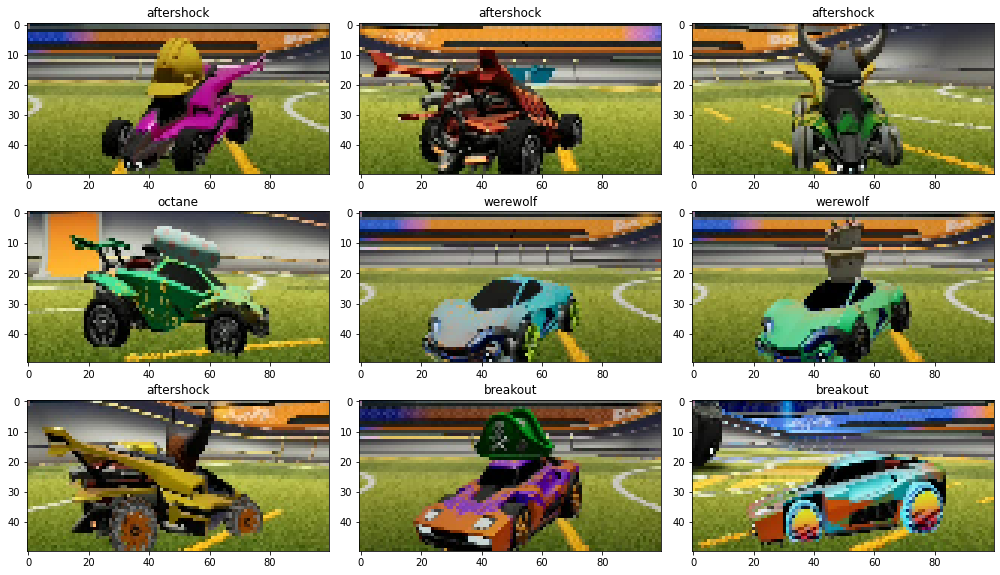

In [55]:
plt.figure(figsize=(14, 8))

for i, d in enumerate(dataset.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.title(CLASSES[d[1]])
    plt.imshow(d[0])

plt.tight_layout()
plt.show()

In [57]:
# build the model
model = Sequential(
    [
        InputLayer(input_shape=RESIZED_SIZE),
        Conv2D(32, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(92, 3, activation="relu", name="conv2d_last"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(250, activation="relu"),
        Dense(4, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 48, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 49, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 22, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_last (Conv2D)        (None, 21, 9, 92)         53084     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 4, 92)       

In [ ]:
# train the model on the dataset
adam = optimizers.Adam(learning_rate=7e-6)
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(dataset_train, validation_data=dataset_validate, epochs=EPOCHS, batch_size=BATCH_SIZE)


In [ ]:
def plot_training_analysis():
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(loss))

    plt.plot(epochs, acc, "b", linestyle="--", label="Training acc")
    plt.plot(epochs, val_acc, "g", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, "b", linestyle="--", label="Training loss")
    plt.plot(epochs, val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.show()


plot_training_analysis()


In [ ]:
# Save the weights
model.save(f"models/full_{EPOCHS}e")